Installing PyTorch Utilities: EfficientNet, TorchMetrics, and TorchInfo

In [1]:
# !pip install efficientnet_pytorch
# !pip install torchmetrics
# !pip install torchinfo
# !pip install opencv-python
# !pip install ultralytics

Importing Libraries for Deep Learning and Data Processing

In [2]:
import os
import zipfile
import torch
from torchvision import datasets
from ultralytics import YOLO
from torchsummary import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import flatten
import torch.optim as optim
import os
import torchvision.transforms as transforms
import seaborn as sns
import torch.optim as optim
from torchmetrics import Accuracy
import time
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import cv2
import shutil
from torch.utils.data import random_split

C:\Users\Ashraf\anaconda3\envs\gpucvip\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Change working Directory

In [3]:
def print_current_directory():
    print("Current Directory:", os.getcwd())

def change_directory(new_directory):
    try:
        os.chdir(new_directory)
        print("Updated Directory:", os.getcwd())
    except FileNotFoundError:
        print(f"Error: The directory '{new_directory}' does not exist.")


print_current_directory()
correct_directory = r'C:\Users\Ashraf\Work\UB\S3\CVIP\Project'
change_directory(correct_directory)

Current Directory: C:\Users\Ashraf\Work\UB\S3\CVIP\Project
Updated Directory: C:\Users\Ashraf\Work\UB\S3\CVIP\Project


CUDA Functions

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    device_name = torch.cuda.get_device_name(0)
    print("Device used : ", device_name)
    device = "cuda"
else:
    print("Device unavailable")
    device = "cpu"

def clear_cuda_cache():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

def print_cuda_memory_stats():
    allocated = torch.cuda.memory_allocated() / 1024**2
    cached = torch.cuda.memory_reserved() / 1024**2
    print(f"Memory Allocated: {allocated:.2f} MB")
    print(f"Memory Reserved (Cached): {cached:.2f} MB")

def free_cuda_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    print("All CUDA memory freed.")

print_cuda_memory_stats()
clear_cuda_cache()

Device used :  NVIDIA GeForce RTX 3080 Ti
Memory Allocated: 0.00 MB
Memory Reserved (Cached): 0.00 MB
CUDA cache cleared.


Checking and Extracting Dataset from ZIP File

In [5]:
def extract_zip_file(zip_path, extract_to='.'):
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            zip_file.extractall(extract_to)
            print(f"Extracted contents of '{zip_path}' to '{extract_to}'.")
    else:
        print(f"File not found: {zip_path}")

dataset_path = './V2 - Traffic Signs.zip'
extract_zip_file(dataset_path)

Extracted contents of './V2 - Traffic Signs.zip' to '.'.


Cropping and Saving Images Based on YOLOv11 Annotations

In [6]:
def crop_and_save_images(images_folder, labels_folder, op_folder):
    for image_file in os.listdir(images_folder):
        if image_file.endswith('.jpg'):
            process_image(image_file, images_folder, labels_folder, op_folder)

def process_image(image_file, images_folder, labels_folder, op_folder):
    image_path = os.path.join(images_folder, image_file)
    image = cv2.imread(image_path)
    if image is None:
        return

    annotation_file_path = os.path.join(labels_folder, os.path.splitext(image_file)[0] + '.txt')
    if not os.path.exists(annotation_file_path):
        print(f"Annotation file does not exist for: {image_file}")
        return

    annotations = read_annotations(annotation_file_path)
    for values in annotations:
        crop_and_save(image, values, image_file, op_folder)

def read_annotations(annotation_file_path):
    with open(annotation_file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip().split() for line in lines]

def crop_and_save(image, annotation_values, image_file, op_folder):
    class_label = int(annotation_values[0])
    x, y, w, h = map(float, annotation_values[1:])

    x1 = int((x - w / 2) * image.shape[1])
    y1 = int((y - h / 2) * image.shape[0])
    x2 = int((x + w / 2) * image.shape[1])
    y2 = int((y + h / 2) * image.shape[0])

    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return

    output_path = os.path.join(op_folder, str(class_label))
    os.makedirs(output_path, exist_ok=True)

    op_file = os.path.join(output_path, f'{os.path.splitext(image_file)[0]}_{class_label}.jpg')
    cv2.imwrite(op_file, roi)

train_images_folder = './V2 - Traffic Signs/train/images'
train_labels_folder = './V2 - Traffic Signs/train/labels'
train_op_folder = './cropped_images/train'

val_images_folder = './V2 - Traffic Signs/valid/images'
val_labels_folder = './V2 - Traffic Signs/valid/labels'
val_op_folder = './cropped_images/val'

crop_and_save_images(train_images_folder, train_labels_folder, train_op_folder)
crop_and_save_images(val_images_folder, val_labels_folder, val_op_folder)

Combining Train and Validation Folders into a Unified Dataset

In [7]:
def combine_folders(train_folder, val_folder, op_folder):
    os.makedirs(op_folder, exist_ok=True)

    class_names = sorted(set(os.listdir(train_folder)) | set(os.listdir(val_folder)))

    for class_name in class_names:
        class_output_path = os.path.join(op_folder, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        train_class_path = os.path.join(train_folder, class_name)
        if os.path.exists(train_class_path):
            copy_files_from_folder(train_class_path, class_output_path)

        val_class_path = os.path.join(val_folder, class_name)
        if os.path.exists(val_class_path):
            copy_files_from_folder(val_class_path, class_output_path)

def copy_files_from_folder(src_folder, dest_folder):
    for filename in os.listdir(src_folder):
        shutil.copy(os.path.join(src_folder, filename), dest_folder)

train_folder = "./cropped_images/train"
val_folder = "./cropped_images/val"
op_folder = "./combined_data"

combine_folders(train_folder, val_folder, op_folder)

Reorganizing and Moving Files with Zero-Padded Directory Names


In [8]:
def create_directories(base_path, num_dirs):
    os.makedirs(base_path, exist_ok=True)
    for i in range(num_dirs):
        dir_name = f"{i:02d}"
        os.makedirs(os.path.join(base_path, dir_name), exist_ok=True)

def move_files_to_padded_dirs(src_dir, dest_dir):
    for dir_name in os.listdir(src_dir):
        src_path = os.path.join(src_dir, dir_name)
        if os.path.isdir(src_path):
            new_dir_name = f"{int(dir_name):02d}" if int(dir_name) < 10 else dir_name
            dest_path = os.path.join(dest_dir, new_dir_name)

            os.makedirs(dest_path, exist_ok=True)

            for filename in os.listdir(src_path):
                shutil.move(os.path.join(src_path, filename), dest_path)

src_dir = "./combined_data"
op_dir = "./combined_data_new"

create_directories(op_dir, 55)

move_files_to_padded_dirs(src_dir, op_dir)

Transforming, Organizing, and Splitting Image Dataset for Training

In [9]:
def get_transform():
    return transforms.Compose([
        transforms.Resize((40, 40)),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

def load_dataset(root_dir, transform):
    return datasets.ImageFolder(root=root_dir, transform=transform)

def get_unique_folders(dataset):
    class_names = dataset.classes
    unique_folders = set()
    for image_path, label in dataset.samples:
        folder_name = class_names[label]
        unique_folders.add((folder_name, label))
    return unique_folders

def print_unique_folders(unique_folders):
    for folder_name, label in unique_folders:
        print(f"Folder Name: {folder_name}, Label: {label}")

def split_dataset(dataset):
    dataset_len = [int(len(dataset) * 0.7), int(len(dataset) * 0.15)]
    dataset_len.append(len(dataset) - sum(dataset_len))
    return random_split(dataset, dataset_len)

transform = get_transform()
dataset = load_dataset(root_dir='combined_data_new', transform=transform)

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

Using PyTorch DataLoader

In [10]:
def create_data_loader(dataset, batch_size=8, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [11]:
train_loader = create_data_loader(train_dataset, batch_size=32, shuffle=False)
test_loader = create_data_loader(test_dataset, batch_size=32, shuffle=False)
val_loader = create_data_loader(val_dataset, batch_size=32, shuffle=False)

Model Training Function with Training and Validation Steps

In [12]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_length = 0
    total_training_loss = 0.0
    train_pred = []

    for data in train_loader:
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        Prob = nn.Softmax(dim=1)(outputs)
        Y_pred = Prob.argmax(1).int()
        train_pred.append(accuracy(Y_pred, target).item())
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_training_loss += loss.item()
        total_length += target.size(0)

    return total_training_loss / total_length, train_pred

def validate_model(model, val_loader, criterion, device):
    model.eval()
    total_length = 0
    total_validation_loss = 0.0
    vald_pred = []

    with torch.no_grad():
        for data in val_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            vald_pred.append(accuracy(Y_pred, target).item())
            val_loss = criterion(outputs, target)
            total_validation_loss += val_loss.item()
            total_length += target.size(0)

    return total_validation_loss / total_length, vald_pred

def log_metrics(epoch, total_training_loss, total_validation_loss, train_pred, vald_pred):
    training_acc_data.append(sum(train_pred) / len(train_pred))
    val_acc_data.append(sum(vald_pred) / len(vald_pred))
    training_loss_data.append(total_training_loss)
    val_loss_data.append(total_validation_loss)
    print(f'Epoch: {epoch+1}, Loss: {total_training_loss}, val_loss: {total_validation_loss}, train_acc: {training_acc_data[-1]}, val_acc : {val_acc_data[-1]}')

def train_model(model, epochs_no, train_loader, test_loader, val_loader, optimizer, criterion, device):
    for epoch in range(epochs_no):
        total_training_loss, train_pred = train_one_epoch(model, train_loader, optimizer, criterion, device)
        total_validation_loss, vald_pred = validate_model(model, val_loader, criterion, device)
        log_metrics(epoch, total_training_loss, total_validation_loss, train_pred, vald_pred)

    return training_loss_data, val_loss_data, training_acc_data, val_acc_data

VGG13 Model Implementation with Dynamic Feature Size Calculation

In [13]:
class VGG13(nn.Module):
    def __init__(self, num_classes=55):
        super(VGG13, self).__init__()
        self.features = self._make_features()
        conv_output_size = self._calculate_conv_output_size()
        self.classifier = self._make_classifier(conv_output_size, num_classes)

    def _make_features(self):
        return nn.Sequential(
            self._make_conv_block(3, 64, 2),
            self._make_conv_block(64, 128, 2),
            self._make_conv_block(128, 256, 2),
            self._make_conv_block(256, 512, 2),
            self._make_conv_block(512, 512, 2)
        )

    def _make_conv_block(self, in_channels, out_channels, num_convs):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]
        return nn.Sequential(*layers)

    def _calculate_conv_output_size(self):
        test_tensor = torch.randn(1, 3, 40, 40)
        with torch.no_grad():
            features_output = self.features(test_tensor)
            return features_output.view(features_output.size(0), -1).size(1)

    def _make_classifier(self, conv_output_size, num_classes):
        return nn.Sequential(
            nn.Linear(conv_output_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Initializing and Training VGG13 Model

In [14]:
def setup_metrics(num_classes, device):
    return Accuracy(task="multiclass", num_classes=num_classes).to(device)

def initialize_training_lists():
    return [], [], [], []

def initialize_vgg_model(num_classes, device, learning_rate, weight_decay):
    model = VGG13(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, criterion, optimizer

num_classes = 55
accuracy = setup_metrics(num_classes, device)
training_loss_data, val_loss_data, training_acc_data, val_acc_data = initialize_training_lists()

vgg, criterion, optimizer = initialize_vgg_model(55, device, 1e-5, 1e-9)

epoch_no = 10
training_loss_data, val_loss_data, training_acc_data, val_acc_data = train_model(
    # vit_resnet_model,
    vgg,
    epoch_no,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    device
)

Epoch: 1, Loss: 0.12139937163067131, val_loss: 0.11482644579986333, train_acc: 0.08627570349545706, val_acc : 0.10101594651738803
Epoch: 2, Loss: 0.11315846665789323, val_loss: 0.11160774488706847, train_acc: 0.100040584447838, val_acc : 0.10101594651738803
Epoch: 3, Loss: 0.10987542568245967, val_loss: 0.1081355780025306, train_acc: 0.1076670725430761, val_acc : 0.11696244859033161
Epoch: 4, Loss: 0.10338512789301511, val_loss: 0.09512403911367748, train_acc: 0.1612215909574713, val_acc : 0.1973058126038975
Epoch: 5, Loss: 0.08897822978449803, val_loss: 0.08070682065842354, train_acc: 0.2493574135005474, val_acc : 0.3006044237150086
Epoch: 6, Loss: 0.0783548249138726, val_loss: 0.07240156474691323, train_acc: 0.32115800873864264, val_acc : 0.3670588988396857
Epoch: 7, Loss: 0.07309544654119582, val_loss: 0.06830305489853557, train_acc: 0.3561282468338807, val_acc : 0.3922325099507968
Epoch: 8, Loss: 0.06962976380000038, val_loss: 0.06514741944144264, train_acc: 0.3756764069909141, val

Model Evaluation and Performance Metrics Calculation

In [15]:
def evaluate_model(model, test_loader, criterion, accuracy, device):
    testing_loss_data = []
    testing_acc_data = []
    testing_pred = []
    Y_test = []
    predictions = []
    total_testing_loss = 0
    total_length = 0

    model.to(device)
    model.eval()

    with torch.no_grad():
        for data in test_loader:
            inputs, target = data
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()

            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            total_length += target.size(0)

            acc = accuracy(Y_pred, target).item()
            testing_pred.append(acc)
            Y_test.append(target)
            predictions.append(Y_pred)

    average_testing_loss = total_testing_loss / total_length
    testing_loss_data.append(average_testing_loss)
    testing_acc_data.append(sum(testing_pred) / len(testing_pred))

    return testing_loss_data, testing_acc_data, predictions, Y_test

def calculate_metrics(Y_pred, Y_test, accuracy):
    Final_accuracy = accuracy(Y_pred, Y_test).item()
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test.cpu(), Y_pred.cpu())
    return Final_accuracy, precision, recall, f1

def print_performance_metrics(training_time, Final_accuracy, precision, recall, f1):
    print("Performance Metrics:")
    print(f"Time to Train : {training_time} seconds")
    print(f"Accuracy      : {Final_accuracy * 100:.2f} %")
    print(f"Precision     : {precision}")
    print(f"Recall        : {recall}")
    print(f"F1 Score      : {f1}")

start_time = time.time()

testing_loss_data, testing_acc_data, predictions, Y_test = evaluate_model(vgg, test_loader, criterion, accuracy, device)

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy, precision, recall, f1 = calculate_metrics(Y_pred, Y_test, accuracy)
training_time = time.time() - start_time

print_performance_metrics(training_time, Final_accuracy, precision, recall, f1)

Performance Metrics:
Time to Train : 6.00868821144104 seconds
Accuracy      : 45.56 %
Precision     : [    0.70833           0     0.17647     0.15179           0           0           0           0     0.25478           0           0           0           0           0           0           0     0.84058           0           0         0.1           0     0.91667     0.95098           0     0.52632     0.72973
           0           0           0           0           0     0.28571     0.26923         0.5           1           0           0           0     0.64948     0.32584         0.6           0     0.15789           0           0           0           0           0           0           0           0     0.16667
           0           0           0]
Recall        : [    0.51515           0     0.44118     0.73913           0           0           0           0     0.71429           0           0           0           0           0           0           0     0.95082           0  

C:\Users\Ashraf\anaconda3\envs\gpucvip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Printing Final Accuracy and Loss Metrics

In [16]:
def calculate_average_loss(loss_data):
    return sum(loss_data) / len(loss_data)

def print_accuracy_and_loss(training_acc_data, val_acc_data, testing_acc_data,
                            training_loss_data, val_loss_data, testing_loss_data):
    print("Accuracy and Loss values:")
    print()
    print(f"Training Accuracy : {training_acc_data[-1]*100:.2f} %")
    print(f"Validation Accuracy : {val_acc_data[-1]*100:.2f} %")
    print(f"Testing Accuracy : {testing_acc_data[-1]*100:.2f} %")
    print()
    print(f"Training Loss : {calculate_average_loss(training_loss_data)}")
    print(f"Validation Loss : {calculate_average_loss(val_loss_data)}")
    print(f"Testing Loss : {calculate_average_loss(testing_loss_data)}")

print_accuracy_and_loss(training_acc_data, val_acc_data, testing_acc_data,
                        training_loss_data, val_loss_data, testing_loss_data)

Accuracy and Loss values:

Training Accuracy : 41.41 %
Validation Accuracy : 44.48 %
Testing Accuracy : 45.49 %

Training Loss : 0.08896464350733325
Validation Loss : 0.0840606585833542
Testing Loss : 0.062232987702100534


Plotting Training and Validation Metrics Over Epochs

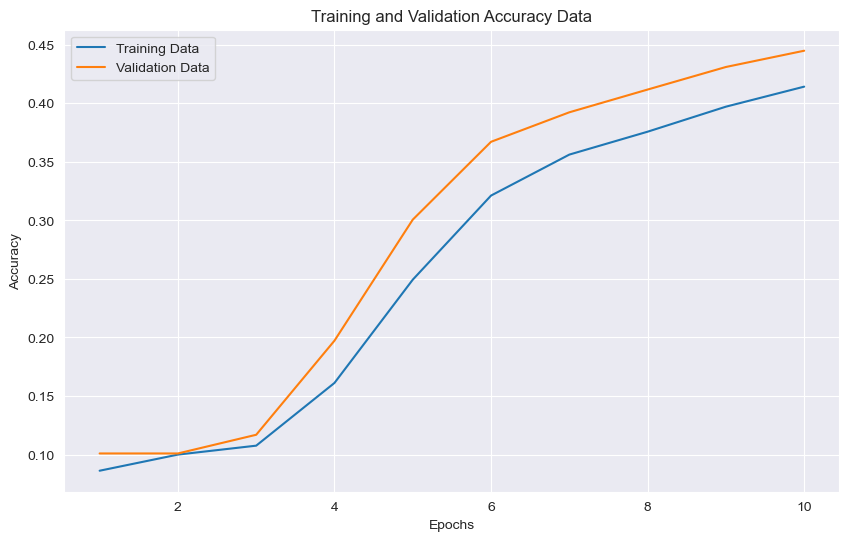

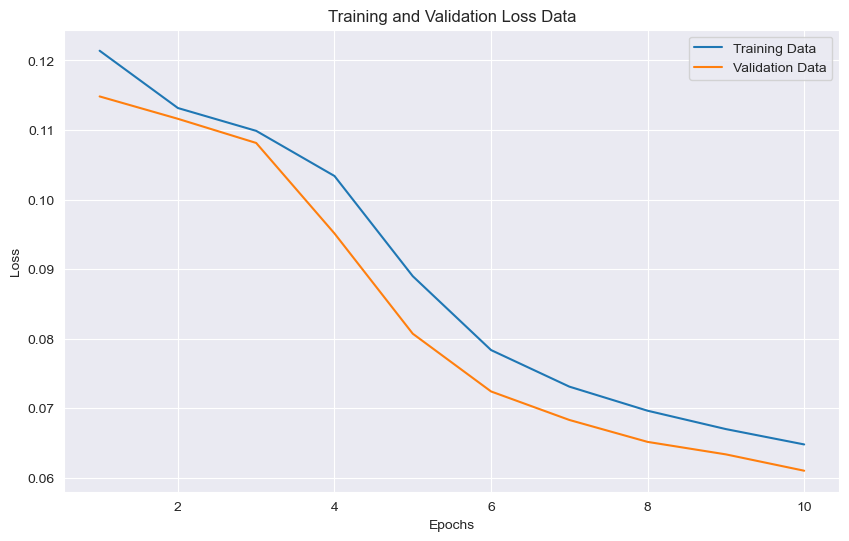

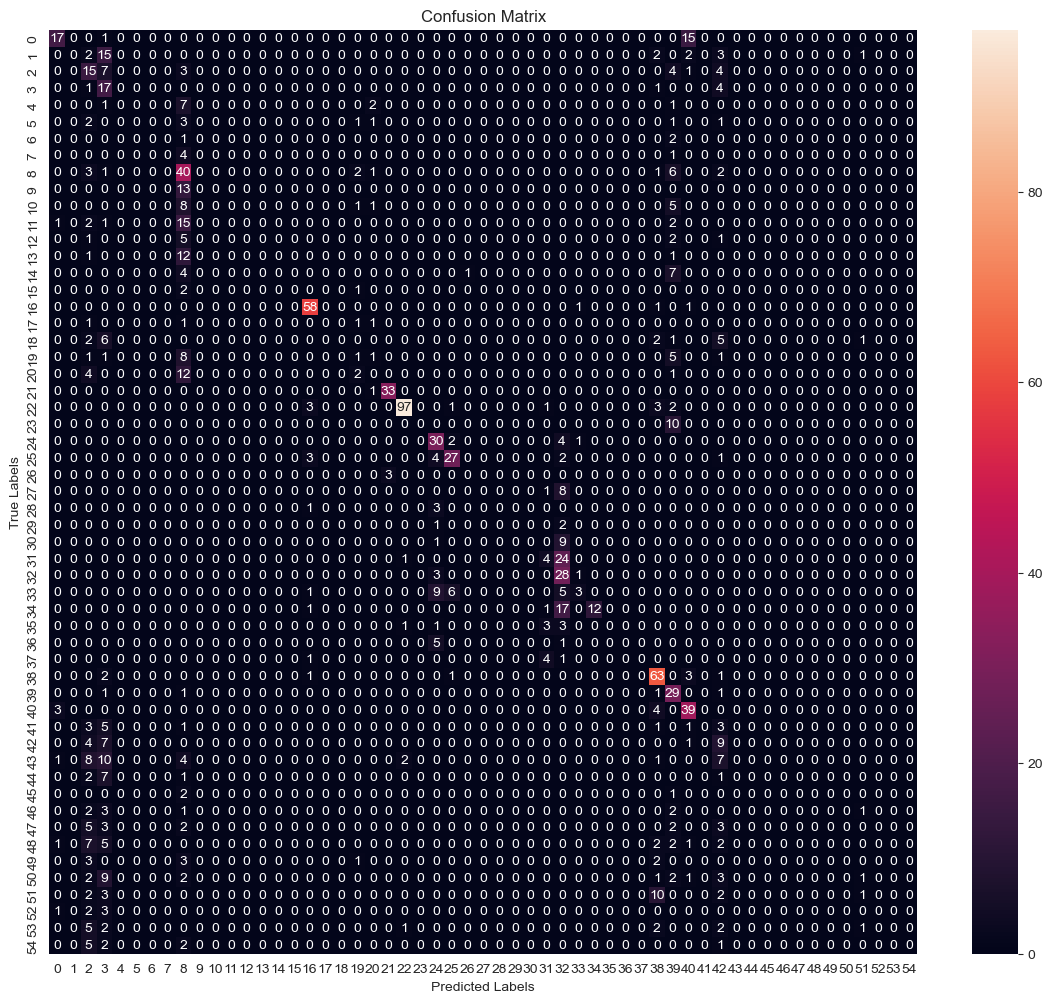

In [17]:
def plot_training_metrics(epochs, training_acc_data, val_acc_data, training_loss_data, val_loss_data):
    def plot_accuracy():
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, training_acc_data, label='Training Data')
        plt.plot(epochs, val_acc_data, label='Validation Data')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy Data')
        plt.legend()
        plt.show()

    def plot_loss():
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, training_loss_data, label='Training Data')
        plt.plot(epochs, val_loss_data, label='Validation Data')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Data')
        plt.legend()

    def plot_confusion_matrix(Y_test, Y_pred):
        cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
        plt.figure(figsize=(14, 12))
        sns.heatmap(cmat, annot=True, fmt="d")
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    plot_accuracy()
    plot_loss()
    plot_confusion_matrix(Y_test, Y_pred)

epochs = range(1, epoch_no+1)
plot_training_metrics(epochs, training_acc_data, val_acc_data, training_loss_data, val_loss_data)

Saving Trained Model Weights

In [18]:
def save_model(model, filepath="name.pth"):
    torch.save(model.state_dict(), filepath)

save_model(vgg,"vgg.pth")

ResNet34 Model Implementation with Residual Blocks

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=55):
        super(ResNet34, self).__init__()
        self.block1 = self._make_initial_block()
        self.block2 = self._make_layer(64, 64, 3)
        self.block3 = self._make_layer(64, 128, 4, stride=2)
        self.block4 = self._make_layer(128, 256, 6, stride=2)
        self.block5 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_initial_block(self):
        return nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResidualBlock(in_channels, out_channels, stride, downsample)]
        layers.extend([ResidualBlock(out_channels, out_channels) for _ in range(1, blocks)])
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Initializing and Training Resnet Model

In [26]:
def initialize_resnet_model(num_classes, device, learning_rate=1e-6, weight_decay=1e-9):
    model = ResNet34(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, criterion, optimizer

num_classes = 55
accuracy = setup_metrics(num_classes, device)
training_loss_data, val_loss_data, training_acc_data, val_acc_data = initialize_training_lists()

resnet, criterion, optimizer = initialize_resnet_model(55, device)

epoch_no = 10
training_loss_data, val_loss_data, training_acc_data, val_acc_data = train_model(
    resnet,
    epoch_no,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    device
)

Epoch: 1, Loss: 0.12889997115433494, val_loss: 0.12475103384116056, train_acc: 0.034970238095238096, val_acc : 0.06819058644274871
Epoch: 2, Loss: 0.11946072306842252, val_loss: 0.11717238588341444, train_acc: 0.1180668290527094, val_acc : 0.1580825617743863
Epoch: 3, Loss: 0.11027106156870096, val_loss: 0.10936489246571282, train_acc: 0.23170319270519985, val_acc : 0.22926311732994187
Epoch: 4, Loss: 0.10093752681151603, val_loss: 0.10152496643033149, train_acc: 0.2978896104863712, val_acc : 0.2771669237150086
Epoch: 5, Loss: 0.09226629500295602, val_loss: 0.09478875233384974, train_acc: 0.35687229445292834, val_acc : 0.3066808126038975
Epoch: 6, Loss: 0.08478743805159597, val_loss: 0.08865133034424254, train_acc: 0.4178503787233716, val_acc : 0.36043595688210595
Epoch: 7, Loss: 0.07823507220359967, val_loss: 0.08345564719169371, train_acc: 0.47659632031406673, val_acc : 0.4121977877285745
Epoch: 8, Loss: 0.07253193501330892, val_loss: 0.0789576138011663, train_acc: 0.5177218616008759

Model Evaluation and Performance Metrics Calculation

In [27]:
start_time = time.time()

testing_loss_data, testing_acc_data, predictions, Y_test = evaluate_model(resnet, test_loader, criterion, accuracy, device)

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy, precision, recall, f1 = calculate_metrics(Y_pred, Y_test, accuracy)
training_time = time.time() - start_time

print_performance_metrics(training_time, Final_accuracy, precision, recall, f1)

Performance Metrics:
Time to Train : 2.591409683227539 seconds
Accuracy      : 51.39 %
Precision     : [0.91891892 0.61363636 0.36956522 0.47619048 0.         0.
 0.         0.         0.28431373 0.         0.         0.25
 0.         0.         0.         0.         0.67647059 0.
 1.         0.125      0.75       0.79487179 0.50802139 0.
 0.625      0.55555556 0.         0.         0.         0.
 0.         0.76       0.42105263 0.82608696 0.76190476 0.
 0.         0.         0.4591195  0.8        0.49462366 0.
 0.5        0.18867925 0.         0.         0.         0.
 0.5        0.         1.         0.33333333 0.         0.
 0.        ]
Recall        : [0.82926829 0.84375    0.68       0.45454545 0.         0.
 0.         0.         0.6744186  0.         0.         0.05263158
 0.         0.         0.         0.         0.85185185 0.
 0.11111111 0.36363636 0.27272727 0.96875    0.97938144 0.
 0.9375     0.55555556 0.         0.         0.         0.
 0.         0.63333333 0.7272727

C:\Users\Ashraf\anaconda3\envs\gpucvip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Printing Final Accuracy and Loss Metrics

In [28]:
print_accuracy_and_loss(training_acc_data, val_acc_data, testing_acc_data,
                        training_loss_data, val_loss_data, testing_loss_data)

Accuracy and Loss values:

Training Accuracy : 59.34 %
Validation Accuracy : 51.79 %
Testing Accuracy : 51.36 %

Training Loss : 0.09168008307448958
Validation Loss : 0.09440249884346827
Testing Loss : 0.0699070126129775


Plotting Training and Validation Metrics Over Epochs

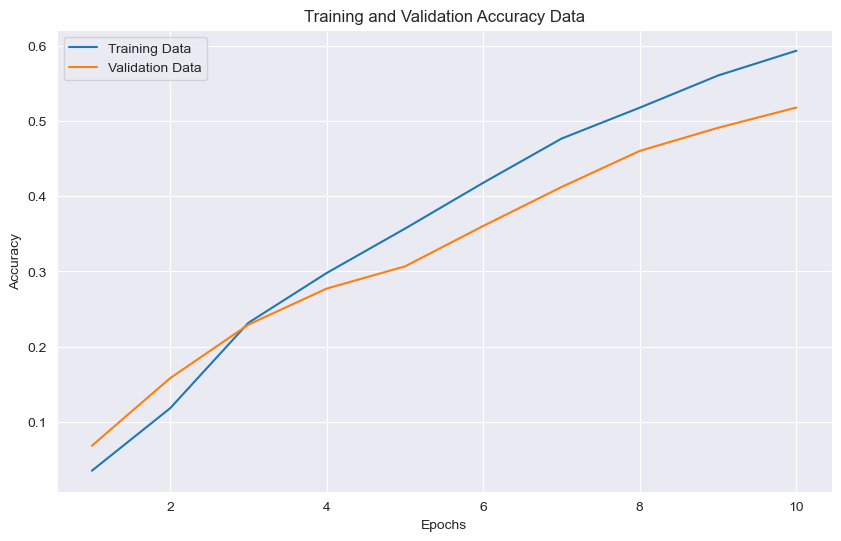

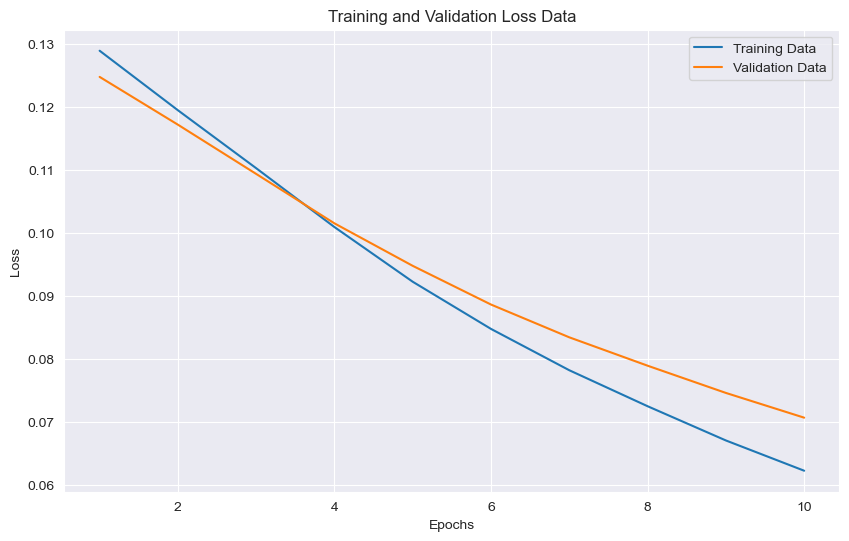

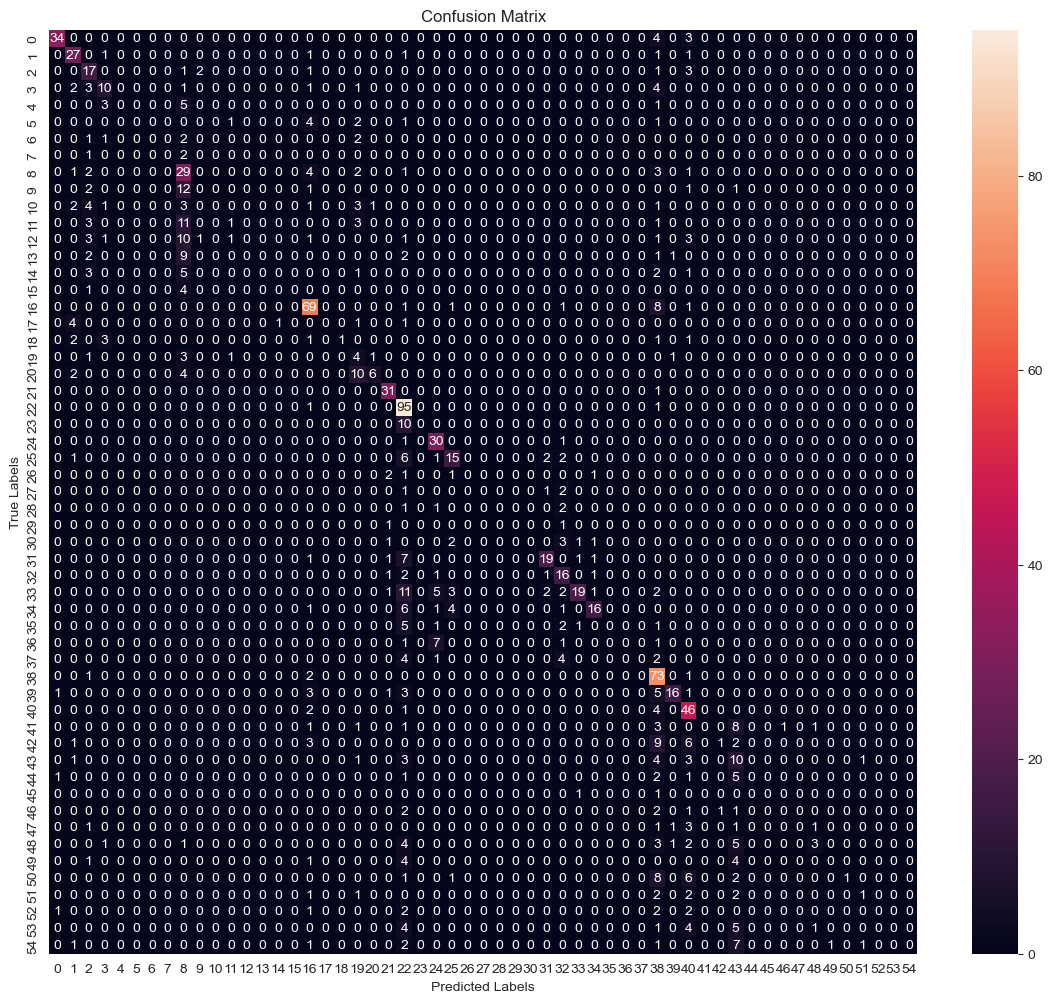

In [29]:
epochs = range(1, epoch_no+1)
plot_training_metrics(epochs, training_acc_data, val_acc_data, training_loss_data, val_loss_data)

Saving Trained Model Weights

In [31]:
save_model(resnet,"resnet.pth")

Vision Transformer Model Implementation

In [35]:
class VisionTransformer_Model(nn.Module):
    def __init__(self, in_channels, img_size, num_classes, embedding_dim, num_attention_heads, patch_size, num_layers):
        super(VisionTransformer_Model, self).__init__()
        self.patch_embedding = self._create_patch_embedding(in_channels, embedding_dim, patch_size)
        self.encoder = self._create_transformer_encoder(embedding_dim, num_attention_heads, num_layers)
        self.op = nn.Linear(embedding_dim, num_classes)

    def _create_patch_embedding(self, in_channels, embedding_dim, patch_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(embedding_dim),
            nn.Flatten(2)
        )

    def _create_transformer_encoder(self, embedding_dim, num_attention_heads, num_layers):
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_attention_heads)
        return nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.op(x)
        return x

Initializing Vision Transformer Model

In [36]:
def initialize_vision_transformer(in_channels, img_size, num_classes, embedding_dim, num_attention_heads, patch_size, num_layers, device):
    model = VisionTransformer_Model(
        in_channels=in_channels,
        img_size=img_size,
        num_classes=num_classes,
        embedding_dim=embedding_dim,
        num_attention_heads=num_attention_heads,
        patch_size=patch_size,
        num_layers=num_layers
    ).to(device)
    return model

in_channels = 3
img_size = 40
num_classes = 55
embedding_dim = 13 * 13
num_attention_heads = 13
patch_size = 3
num_layers = 12

vision_transformer = initialize_vision_transformer(
    in_channels,
    img_size,
    num_classes,
    embedding_dim,
    num_attention_heads,
    patch_size,
    num_layers,
    device
)

Initializing and Training Vision Transformer Model

In [39]:
def initialize_vision_transformer_model(model, device, learning_rate=1e-5, weight_decay=1e-9):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, criterion, optimizer

num_classes = 55
accuracy = setup_metrics(num_classes, device)
vision_transformer, criterion, optimizer = initialize_vision_transformer_model(vision_transformer, device)

epoch_no = 10
training_loss_data, val_loss_data, training_acc_data, val_acc_data = train_model(
    vision_transformer,
    epoch_no,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    device
)

Epoch: 1, Loss: 0.11806731197346493, val_loss: 0.11622601815068212, train_acc: 0.09858630952380952, val_acc : 0.0956468621475829
Epoch: 2, Loss: 0.11435135000782744, val_loss: 0.1121719257667362, train_acc: 0.10993303571428571, val_acc : 0.16644161525699827
Epoch: 3, Loss: 0.10445375976776208, val_loss: 0.09704484602837533, train_acc: 0.2309591450861522, val_acc : 0.301954732173019
Epoch: 4, Loss: 0.08848046744459706, val_loss: 0.08347775339560605, train_acc: 0.3810369319149426, val_acc : 0.3998199585411284
Epoch: 5, Loss: 0.07637672195024962, val_loss: 0.07352461052024063, train_acc: 0.48831507031406673, val_acc : 0.4817386832502153
Epoch: 6, Loss: 0.06727509200294701, val_loss: 0.06562545763063972, train_acc: 0.5549073322188287, val_acc : 0.539030349916882
Epoch: 7, Loss: 0.05992842800254359, val_loss: 0.059308776568618146, train_acc: 0.597132034599781, val_acc : 0.5825938781102499
Epoch: 8, Loss: 0.05403206985092519, val_loss: 0.054324665689011085, train_acc: 0.6281960226950192, val

Model Evaluation and Performance Metrics Calculation

In [40]:
start_time = time.time()

testing_loss_data, testing_acc_data, predictions, Y_test = evaluate_model(vision_transformer, test_loader, criterion, accuracy, device)

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy, precision, recall, f1 = calculate_metrics(Y_pred, Y_test, accuracy)
training_time = time.time() - start_time

print_performance_metrics(training_time, Final_accuracy, precision, recall, f1)

Performance Metrics:
Time to Train : 2.6587347984313965 seconds
Accuracy      : 66.20 %
Precision     : [0.91111111 0.78378378 0.77419355 0.68965517 0.         0.
 0.         0.         0.26717557 0.         0.84210526 0.25
 0.         0.         0.         0.         0.72477064 0.
 0.         0.41176471 0.9        0.81578947 0.74603175 1.
 0.64       0.84615385 0.         0.         0.         0.
 0.         0.875      0.43181818 0.82692308 0.75757576 1.
 0.         0.88888889 0.7816092  0.74285714 0.87719298 0.75
 0.44444444 0.4        0.         0.         0.         1.
 0.57142857 0.         0.625      1.         0.         0.
 0.25      ]
Recall        : [1.         0.90625    0.96       0.90909091 0.         0.
 0.         0.         0.81395349 0.         1.         0.10526316
 0.         0.         0.         0.         0.97530864 0.
 0.         0.63636364 0.40909091 0.96875    0.96907216 0.2
 1.         0.81481481 0.         0.         0.         0.
 0.         0.93333333 0.863

C:\Users\Ashraf\anaconda3\envs\gpucvip\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Printing Final Accuracy and Loss Metrics

In [41]:
print_accuracy_and_loss(training_acc_data, val_acc_data, testing_acc_data,
                        training_loss_data, val_loss_data, testing_loss_data)

Accuracy and Loss values:

Training Accuracy : 68.23 %
Validation Accuracy : 64.79 %
Testing Accuracy : 66.17 %

Training Loss : 0.09068657049079502
Validation Loss : 0.09108906540361493
Testing Loss : 0.044132684321769027


Plotting Training and Validation Metrics Over Epochs

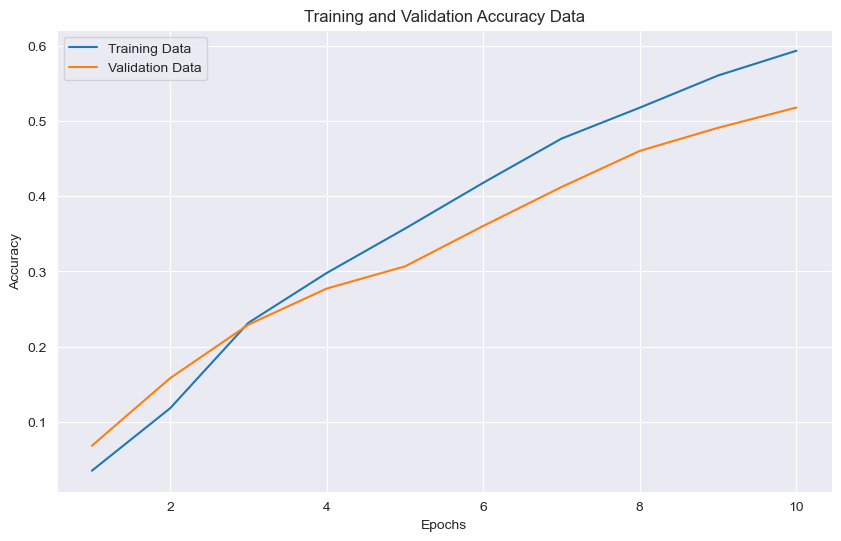

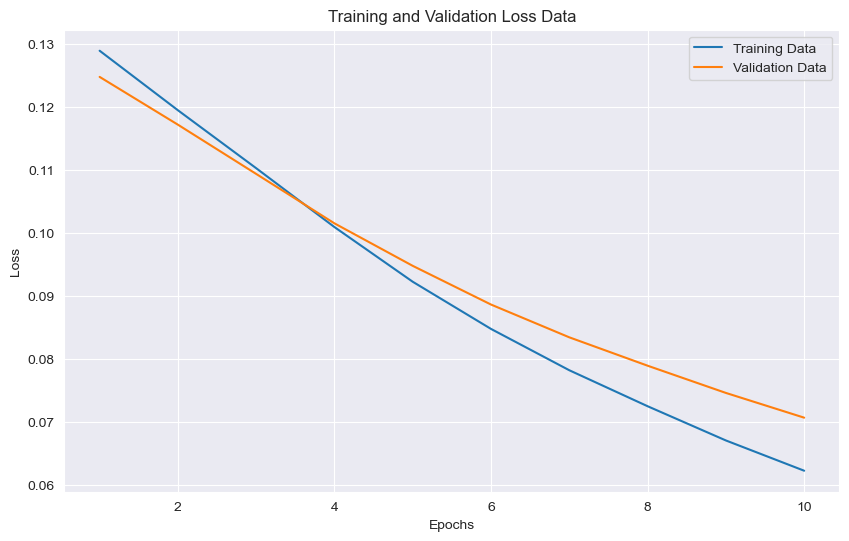

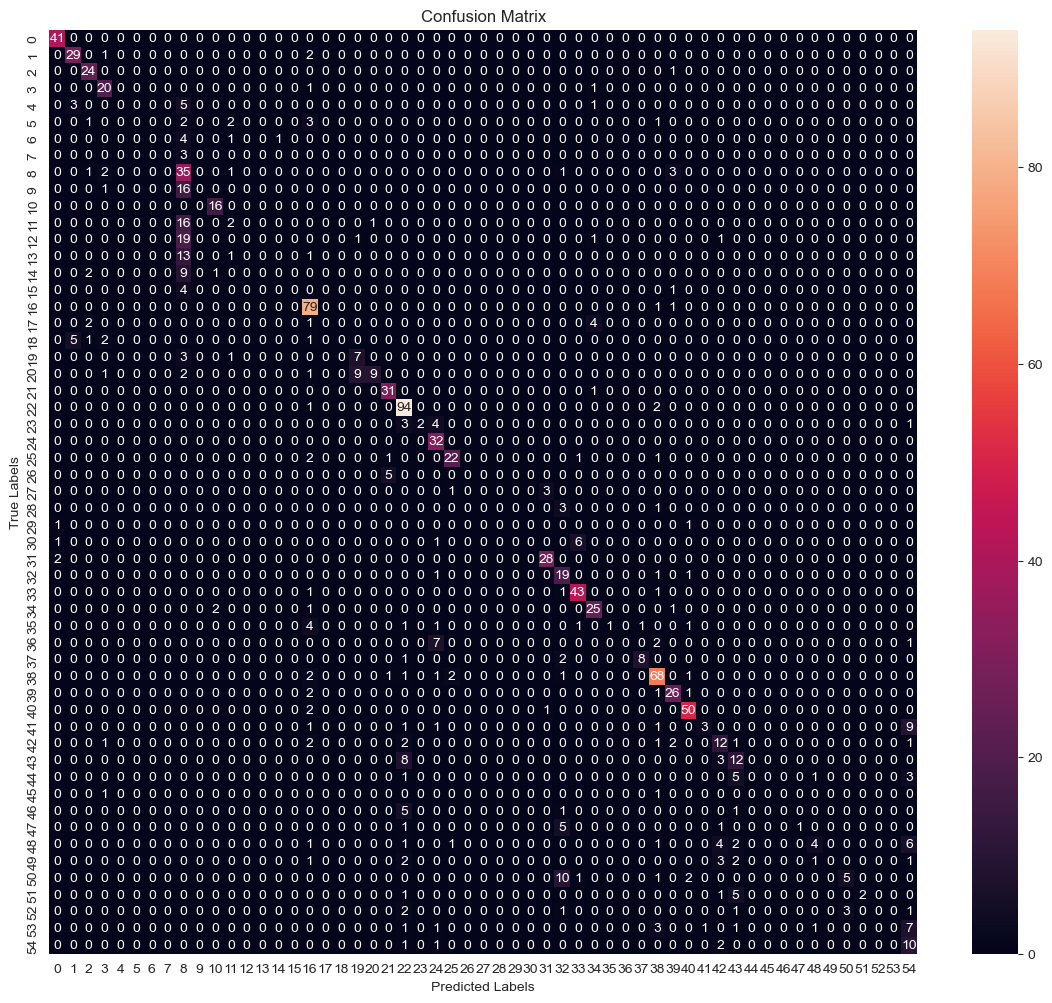

In [47]:
def plot_accuracy_and_loss(epochs, training_acc_data, val_acc_data, training_loss_data, val_loss_data):
    num_epochs = len(epochs)
    training_acc_data = training_acc_data[:num_epochs]
    val_acc_data = val_acc_data[:num_epochs]
    training_loss_data = training_loss_data[:num_epochs]
    val_loss_data = val_loss_data[:num_epochs]

    plot_training_metrics(epochs, training_acc_data, val_acc_data, training_loss_data, val_loss_data)

epochs = range(1, epoch_no + 1)
plot_accuracy_and_loss(epochs, training_acc_data, val_acc_data, training_loss_data, val_loss_data)

Saving Trained Model Weights

In [48]:
save_model(vision_transformer,"vision_transformer.pth")

In [19]:
free_cuda_memory()

All CUDA memory freed.


VIT ResNet Hybrid Model

Transforming, Organizing, and Splitting Image Dataset for Training

In [20]:
transform = get_transform()
dataset = load_dataset(root_dir='combined_data_new', transform=transform)

unique_folders = get_unique_folders(dataset)
print_unique_folders(unique_folders)

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

Folder Name: 33, Label: 33
Folder Name: 28, Label: 28
Folder Name: 17, Label: 17
Folder Name: 37, Label: 37
Folder Name: 44, Label: 44
Folder Name: 08, Label: 8
Folder Name: 09, Label: 9
Folder Name: 12, Label: 12
Folder Name: 41, Label: 41
Folder Name: 20, Label: 20
Folder Name: 25, Label: 25
Folder Name: 07, Label: 7
Folder Name: 02, Label: 2
Folder Name: 00, Label: 0
Folder Name: 11, Label: 11
Folder Name: 06, Label: 6
Folder Name: 16, Label: 16
Folder Name: 48, Label: 48
Folder Name: 03, Label: 3
Folder Name: 01, Label: 1
Folder Name: 15, Label: 15
Folder Name: 24, Label: 24
Folder Name: 27, Label: 27
Folder Name: 13, Label: 13
Folder Name: 42, Label: 42
Folder Name: 36, Label: 36
Folder Name: 46, Label: 46
Folder Name: 32, Label: 32
Folder Name: 14, Label: 14
Folder Name: 45, Label: 45
Folder Name: 18, Label: 18
Folder Name: 30, Label: 30
Folder Name: 52, Label: 52
Folder Name: 50, Label: 50
Folder Name: 34, Label: 34
Folder Name: 31, Label: 31
Folder Name: 53, Label: 53
Folder Na

Dataset Analysis

In [21]:
def print_dataset_info(dataset):
    print("Total Number of images:", len(dataset))
    print("Classes in the dataset:", dataset.classes)

print_dataset_info(dataset)

Total Number of images: 7650
Classes in the dataset: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54']


Visualizing a Batch of Images with Class Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


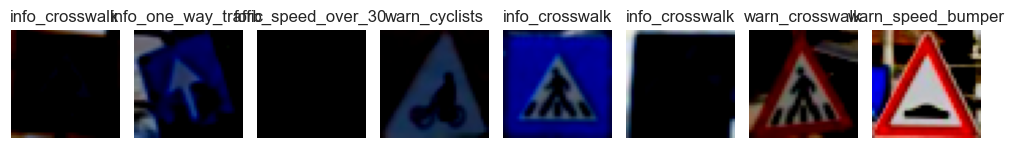

In [22]:
def get_labels_map():
    return {
        0: 'forb_ahead', 1: 'forb_left', 2: 'forb_overtake', 3: 'forb_right',
        4: 'forb_speed_over_10', 5: 'forb_speed_over_100', 6: 'forb_speed_over_130',
        7: 'forb_speed_over_20', 8: 'forb_speed_over_30', 9: 'forb_speed_over_40',
        10: 'forb_speed_over_5', 11: 'forb_speed_over_50', 12: 'forb_speed_over_60',
        13: 'forb_speed_over_70', 14: 'forb_speed_over_80', 15: 'forb_speed_over_90',
        16: 'forb_stopping', 17: 'forb_trucks', 18: 'forb_u_turn',
        19: 'forb_weight_over_3.5t', 20: 'forb_weight_over_7.5t',
        21: 'info_bus_station', 22: 'info_crosswalk', 23: 'info_highway',
        24: 'info_one_way_traffic', 25: 'info_parking', 26: 'info_taxi_parking',
        27: 'mand_bike_lane', 28: 'mand_left', 29: 'mand_left_right',
        30: 'mand_pass_left', 31: 'mand_pass_left_right', 32: 'mand_pass_right',
        33: 'mand_right', 34: 'mand_roundabout', 35: 'mand_straigh_left',
        36: 'mand_straight', 37: 'mand_straight_right',
        38: 'prio_give_way', 39: 'prio_priority_road',
        40: 'prio_stop',41:'warn_children',
        42:'warn_construction',
        43:'warn_crosswalk',
        44:'warn_cyclists',
        45:'warn_domestic_animals',
        46:'warn_other_dangers',
        47:'warn_poor_road_surface',
        48:'warn_roundabout',
        49:'warn_slippery_road',
        50:'warn_speed_bumper',
        51:'warn_traffic_light',
        52:'warn_tram',
        53:'warn_two_way_traffic',
        54:'warn_wild_animals'
    }

def plot_images(images, labels, labels_map):
    fig, ax = plt.subplots(1, len(images), figsize=(10,3))
    for i, img in enumerate(images):
        img_np = img.permute(1,2,0).numpy()
        index = labels[i].item()
        ax[i].imshow(img_np.squeeze(), cmap="gray")
        ax[i].set_title(labels_map[index])
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()

data_loader = create_data_loader(dataset)
images, labels = next(iter(data_loader))
labels_map = get_labels_map()
plot_images(images, labels, labels_map)

Counting and Visualizing the Number of Samples per Class

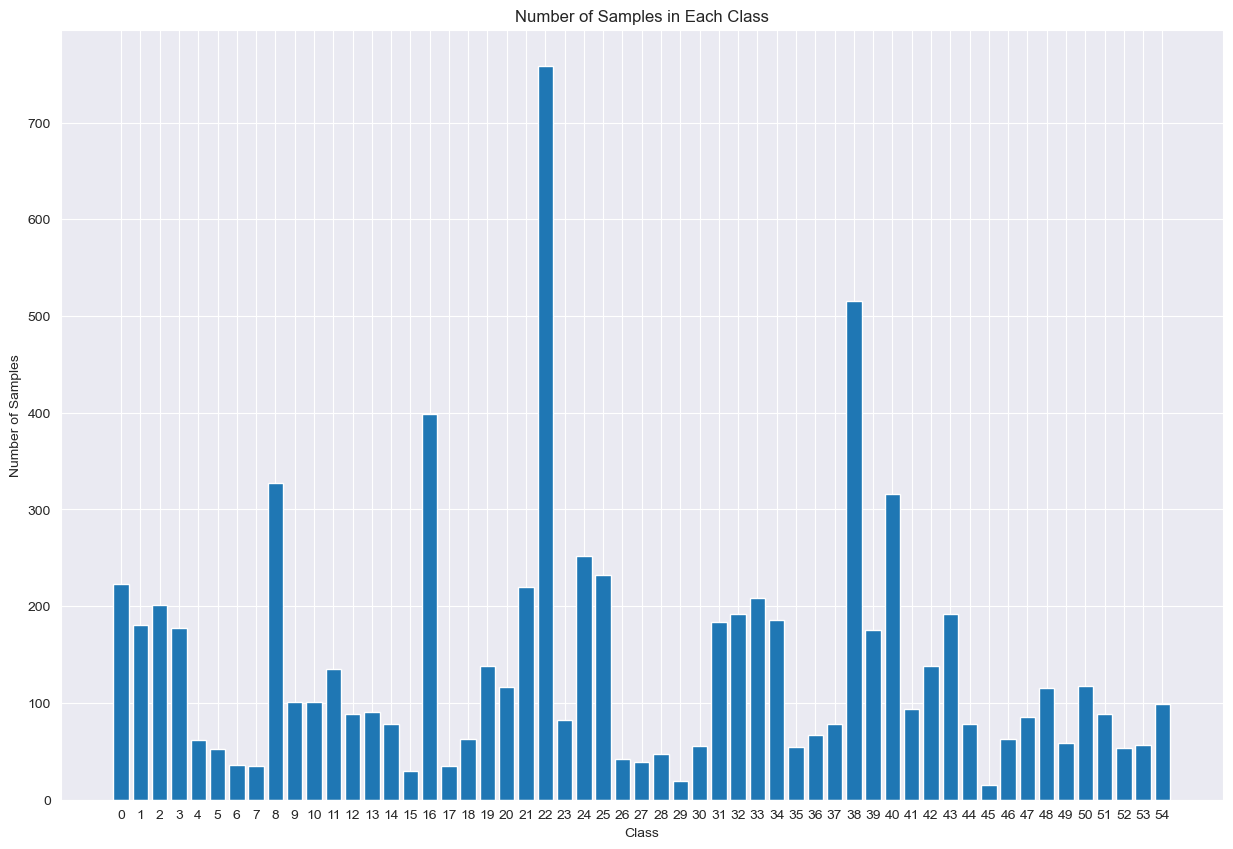

In [23]:
def count_class_samples(dataset):
    class_counts = {}
    for _, label in dataset:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
    return class_counts

def plot_class_distribution(class_counts):
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(15, 10))
    plt.bar(labels, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Number of Samples in Each Class')
    plt.xticks(np.arange(len(labels)), labels)
    plt.show()

class_counts = count_class_samples(dataset)
plot_class_distribution(class_counts)

Creating Data Loaders for Training, Validation, and Test Datasets

In [24]:
train_loader = create_data_loader(train_dataset, batch_size=32, shuffle=False)
test_loader = create_data_loader(test_dataset, batch_size=32, shuffle=False)
val_loader = create_data_loader(val_dataset, batch_size=32, shuffle=False)

Dataset Analysis: Counting Images in Training, Validation, and Testing Sets

In [25]:
def print_dataset_sizes(train_dataset, val_dataset, test_dataset):
    print("Total Number of images in Training Data:", len(train_dataset))
    print("Total Number of images in Validation Data:", len(val_dataset))
    print("Total Number of images in Testing Data:", len(test_dataset))

print_dataset_sizes(train_dataset, val_dataset, test_dataset)

Total Number of images in Training Data: 5355
Total Number of images in Validation Data: 1147
Total Number of images in Testing Data: 1148


Defining and Initializing Combined VisionTransformer-ResNet Model

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=169):
        super(ResNet34, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block2 = self._make_layer(64, 64, 3)
        self.block3 = self._make_layer(64, 128, 4, stride=2)
        self.block4 = self._make_layer(128, 256, 6, stride=2)
        self.block5 = self._make_layer(256, 512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class VisionTransformer_Model(nn.Module):
    def __init__(self, in_channels, img_size, embedding_dim, num_attention_heads, patch_size, num_layers):
        super(VisionTransformer_Model, self).__init__()
        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size),
            nn.BatchNorm2d(embedding_dim),
            nn.Flatten(2)
        )
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_attention_heads), num_layers=num_layers
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return x

class VisionTransformer_ResNet_Concatenator(nn.Module):
    def __init__(self, vision_model, resnet_model, conv1d_out_channels, num_classes):
        super(VisionTransformer_ResNet_Concatenator, self).__init__()
        self.vision_model = vision_model
        self.resnet_model = resnet_model
        self.conv1d_out_channels = conv1d_out_channels
        with torch.no_grad():
            resnet_output_dim = resnet_model(torch.zeros(1, 3, 40, 40).to(device)).shape[1]
            vit_output_dim = vision_model(torch.zeros(1, 3, 40, 40).to(device)).shape[1]
        self.concat_dim = vit_output_dim + resnet_output_dim
        self.conv1d = nn.Conv1d(self.concat_dim, conv1d_out_channels, kernel_size=1)
        self.fc = nn.Linear(conv1d_out_channels, num_classes)

    def forward(self, x):
        vit_output = self.vision_model(x)
        resnet_output = self.resnet_model(x)
        concatenated_output = torch.cat((vit_output, resnet_output), dim=1)
        concatenated_output = concatenated_output.unsqueeze(2)
        concatenated_output = concatenated_output.permute(0, 1, 2)
        conv1d_output = self.conv1d(concatenated_output)
        conv1d_output = conv1d_output.squeeze(2)
        output = self.fc(conv1d_output)
        return output

def initialize_models(device):
    resnet_model_con = ResNet34().to(device)
    in_channels, img_size, embedding_dim_vision = 3, 40, 13 * 13
    num_attention_heads, patch_size, num_layers = 13, 3, 12
    vit_model_con = VisionTransformer_Model(in_channels, img_size, embedding_dim_vision, num_attention_heads, patch_size, num_layers).to(device)
    return resnet_model_con, vit_model_con

resnet_model_con, vit_model_con = initialize_models(device)
conv1d_out_channels = 128
num_classes = 55
vit_resnet_model = VisionTransformer_ResNet_Concatenator(vit_model_con, resnet_model_con, conv1d_out_channels, num_classes).to(device)
print(vit_resnet_model)

VisionTransformer_ResNet_Concatenator(
  (vision_model): VisionTransformer_Model(
    (patch_embedding): Sequential(
      (0): Conv2d(3, 169, kernel_size=(3, 3), stride=(3, 3))
      (1): BatchNorm2d(169, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Flatten(start_dim=2, end_dim=-1)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=169, out_features=169, bias=True)
          )
          (linear1): Linear(in_features=169, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=169, bias=True)
          (norm1): LayerNorm((169,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((169,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (drop

C:\Users\Ashraf\anaconda3\envs\gpucvip\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\Ashraf\anaconda3\envs\gpucvip\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


 Model Training Components and Training Configuration

In [27]:
def setup_model_components(vit_model_con, resnet_model_con, conv1d_out_channels, num_classes, device, learning_rate=1e-4, weight_decay=1e-5):
    model = VisionTransformer_ResNet_Concatenator(vit_model_con, resnet_model_con, conv1d_out_channels, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, criterion, optimizer

num_classes = 55
accuracy = setup_metrics(num_classes, device)
training_loss_data, val_loss_data, training_acc_data, val_acc_data = initialize_training_lists()

vit_resnet_model, criterion, optimizer = setup_model_components(
    vit_model_con,
    resnet_model_con,
    conv1d_out_channels,
    num_classes,
    device
)

epoch_no = 20
training_loss_data, val_loss_data, training_acc_data, val_acc_data = train_model(
    vit_resnet_model,
    epoch_no,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    device
)

Epoch: 1, Loss: 0.06649317789255849, val_loss: 0.03589674848624697, train_acc: 0.4855587120567049, val_acc : 0.6752507719728682
Epoch: 2, Loss: 0.025283814617454395, val_loss: 0.019421696818799898, train_acc: 0.7859172079534757, val_acc : 0.8354552470975452
Epoch: 3, Loss: 0.013158517842199288, val_loss: 0.015535971044246904, train_acc: 0.8859916127153805, val_acc : 0.8635545273621877
Epoch: 4, Loss: 0.008495944437164775, val_loss: 0.014737323985322206, train_acc: 0.9270833333333334, val_acc : 0.8816229419575797
Epoch: 5, Loss: 0.006128469933551344, val_loss: 0.010906509632843935, train_acc: 0.9464285714285714, val_acc : 0.9184027777777778
Epoch: 6, Loss: 0.0037725398852642067, val_loss: 0.012953750103867978, train_acc: 0.9715401785714286, val_acc : 0.9121656384732988
Epoch: 7, Loss: 0.0034394578956046694, val_loss: 0.01092158526558926, train_acc: 0.9717261904761905, val_acc : 0.9206854419575797
Epoch: 8, Loss: 0.003081668731186932, val_loss: 0.014280570773269783, train_acc: 0.97377232

Model Evaluation and Performance Metrics Calculation

In [28]:
start_time = time.time()

testing_loss_data, testing_acc_data, predictions, Y_test = evaluate_model(vit_resnet_model, test_loader, criterion, accuracy, device)

Y_pred = torch.cat([p for p in predictions])
Y_test = torch.cat([t for t in Y_test])
Final_accuracy, precision, recall, f1 = calculate_metrics(Y_pred, Y_test, accuracy)
training_time = time.time() - start_time

print_performance_metrics(training_time, Final_accuracy, precision, recall, f1)

Performance Metrics:
Time to Train : 2.9904186725616455 seconds
Accuracy      : 94.25 %
Precision     : [    0.96552           1           1     0.96774     0.92308     0.88889           1         0.8     0.97619           1           1     0.94118           1     0.92857        0.75     0.57143     0.94545           1           1           1           1     0.92593     0.97115           1     0.95122     0.97917
           1     0.83333     0.83333        0.75         0.9           1      0.9375     0.92593           1           1     0.92857           1      0.8875           1     0.98305     0.92857     0.85714     0.90625     0.66667           1     0.83333           1     0.93333     0.73333     0.82353           1
           1         0.8     0.88889]
Recall        : [    0.96552        0.92           1     0.96774     0.92308           1         0.8           1     0.95349           1     0.92308     0.88889           1     0.92857        0.75           1     0.91228           1

Printing Final Accuracy and Loss Metrics

In [29]:
print_accuracy_and_loss(training_acc_data, val_acc_data, testing_acc_data,
                        training_loss_data, val_loss_data, testing_loss_data)

Accuracy and Loss values:

Training Accuracy : 99.18 %
Validation Accuracy : 94.17 %
Testing Accuracy : 94.25 %

Training Loss : 0.007659281182407102
Validation Loss : 0.01374616350584506
Testing Loss : 0.0107302970454934


Plotting Training and Validation Metrics Over Epochs

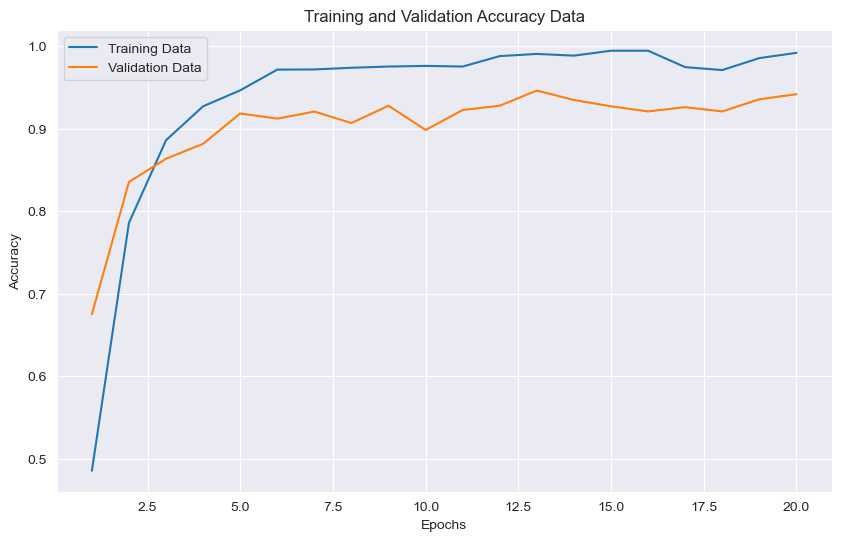

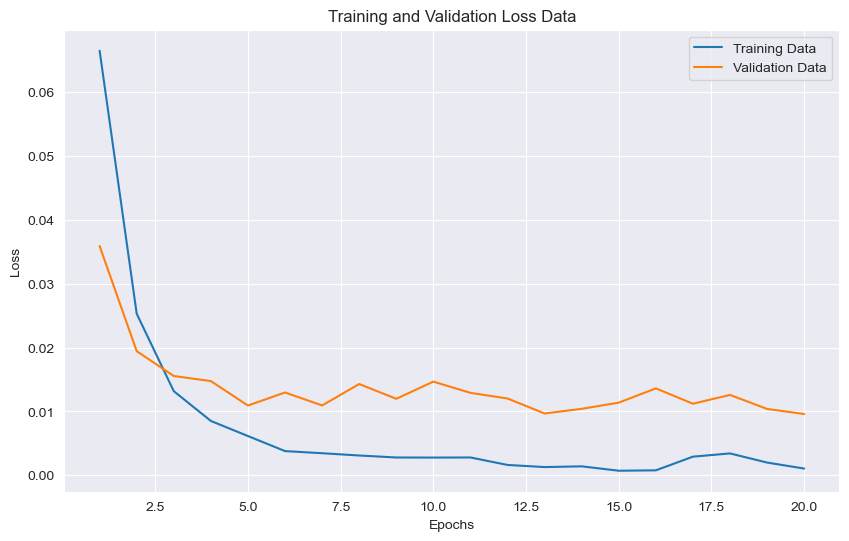

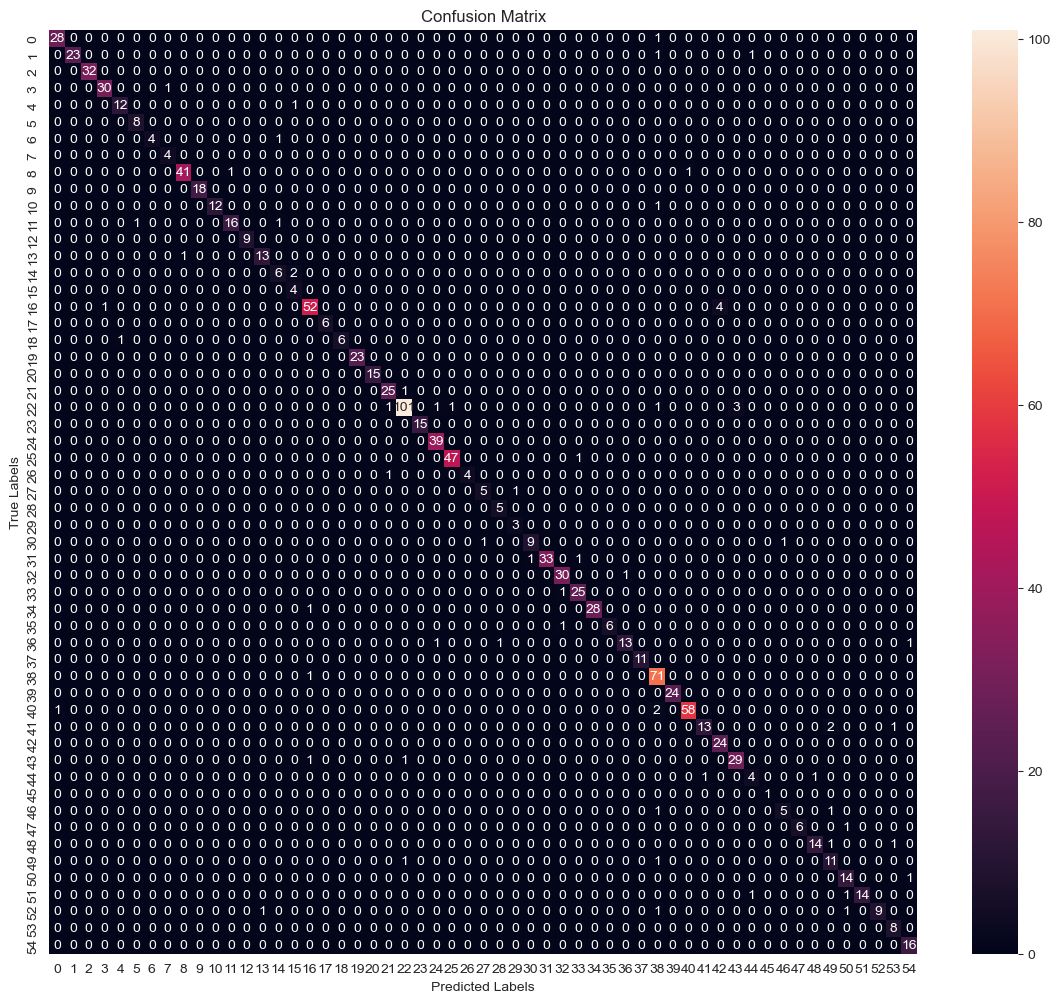

In [30]:
epochs = range(1, epoch_no+1)
plot_training_metrics(epochs, training_acc_data, val_acc_data, training_loss_data, val_loss_data)

Saving Trained Model Weights

In [31]:
save_model(vit_resnet_model,"vit_resnet_modelyolo.pth")